# Deadtrees AutoEncoder Experiments

In [1]:
import deadtrees
from omegaconf import DictConfig
import torch
from torch import Tensor

from typing import Any, Dict, Tuple

import pytorch_lightning as pl
from pytorch_lightning.loggers.wandb import WandbLogger

In [2]:
from pytorch_lightning.loggers import WandbLogger
wandb_logger = WandbLogger()

In [3]:
from torchmetrics import MeanSquaredError

In [4]:
#from deadtrees.network.segmodel import SemSegment
from deadtrees.data.deadtreedata import DeadtreesDataModule
from deadtrees.visualization.helper import rgbtensor_to_rgb
from deadtrees.network.extra.efficientunetplusplus import EfficientUnetPlusPlusAutoencoder

In [5]:
from typing import Optional

import torch
from deadtrees.utils import utils
from pytorch_lightning import Callback

log = utils.get_logger(__name__)


class MultiStage(Callback):
    def __init__(
        self,
        *,
        switch_lr_scheduler: int,
    ):
        super().__init__()
        self.switch_lr_scheduler = switch_lr_scheduler 

    def on_train_epoch_start(self, trainer, pl_module):

        if trainer.current_epoch == self.switch_lr_scheduler:
            # also use unfrozen encoder, lower learning rate
            log.info(
                f"NEW STAGE (epoch: {trainer.current_epoch}): Change LR scheduler"
            )
            new_optimizer = torch.optim.Adam(
                pl_module.parameters(),
                lr=pl_module.hparams.training.learning_rate,
            )
            new_scheduler = torch.optim.lr_scheduler.ExponentialLR(new_optimizer, gamma=0.9)
            trainer.optimizers = [new_optimizer]
            trainer.lr_schedulers = trainer._configure_schedulers(
                [new_scheduler], monitor=None, is_manual_optimization=False
            )
            trainer.optimizer_frequencies = (
                []
            )  # or optimizers frequencies if you have any

            
            
import wandb
from pytorch_lightning import Callback, Trainer
from pytorch_lightning.loggers import LoggerCollection, WandbLogger


def get_wandb_logger(trainer: Trainer) -> WandbLogger:
    if isinstance(trainer.logger, WandbLogger):
        return trainer.logger

    if isinstance(trainer.logger, LoggerCollection):
        for logger in trainer.logger:
            if isinstance(logger, WandbLogger):
                return logger

    raise Exception(
        "You are using wandb related callback, but WandbLogger was not found for some reason..."
    )

            

class WatchModelWithWandb(Callback):
    """Make WandbLogger watch model at the beginning of the run."""

    def __init__(self, log: str = "gradients", log_freq: int = 100):
        self.log = log
        self.log_freq = log_freq

    def on_train_start(self, trainer, pl_module):
        logger = get_wandb_logger(trainer=trainer)
        logger.watch(model=trainer.model, log=self.log, log_freq=self.log_freq)



In [6]:
model = EfficientUnetPlusPlusAutoencoder(
    encoder_name="efficientnet-b5",
    decoder_channels=[256, 128, 64, 32, 16],
    encoder_depth=5,
    encoder_weights="imagenet",
    classes=3,
    in_channels=4,
)

In [7]:
network_conf = DictConfig(
    dict(
        encoder_name="efficientnet-b5",
        decoder_channels=[256, 128, 64, 32, 16],
        encoder_depth=5,
        encoder_weights=None, #"imagenet",
        classes=["background", "conifers", "deciduous"],
        in_channels=4,
    )
)

training_conf = DictConfig(
    dict(
        learning_rate=0.0003,
        cosineannealing_tmax=10
    )
)

In [8]:

def concat_extra(
    img: Tensor, mask: Tensor, distmap: Tensor, lu: Tensor, stats, *, extra
) -> Tuple[Tensor]:
    extra_imgs, extra_masks, extra_distmaps, extra_lus, extra_stats = list(zip(*extra))
    img = torch.cat((img, *extra_imgs), dim=0)
    mask = torch.cat((mask, *extra_masks), dim=0)
    distmap = torch.cat((distmap, *extra_distmaps), dim=0)
    lu = torch.cat((lu, *extra_lus), dim=0)
    stats.extend(sum(extra_stats, []))
    return img, mask, distmap, lu, stats


def create_combined_batch(
    batch: Dict[str, Any]
) -> Tuple[Tensor, Tensor, Tensor, Tensor]:
    img, mask, distmap, lu, stats = batch["main"]

    # grab extra datasets and concat tensors
    extra = [v for k, v in batch.items() if k.startswith("extra")]
    if extra:
        img, mask, distmap, lu, stats = concat_extra(
            img, mask, distmap, lu, stats, extra=extra
        )
    return img, mask, distmap, lu, stats



In [9]:
class SemSegmentAutoencoder(pl.LightningModule):  # type: ignore
    def __init__(self, network: DictConfig, training: DictConfig):
        super().__init__()

        # Model does not accept "architecture" as an argument, but we need to store it in hparams for inference
        # TODO: cleanup?
        clean_network_conf = network.copy()

        self.model = EfficientUnetPlusPlusAutoencoder(**clean_network_conf)

        if clean_network_conf.encoder_weights is None:
            #log.info("Initializing unset weights with Kaiming")
            print("Initializing unset weights with Kaiming")
            self.model.apply(initialize_weights)
        self.encoder_weights = clean_network_conf.encoder_weights

        self.save_hyperparameters()

        self.in_channels = self.hparams["network"]["in_channels"]

        # losses
        self.loss = torch.nn.MSELoss()

        self.metric = MeanSquaredError()

        
    def log_metrics(self, x: Tensor, y_hat: Tensor, *, stage: str):
        score = self.metric(y_hat, x) 
        self.log(f"{stage}/mse", score, on_step=False, on_epoch=True)        

        
    def training_step(self, batch, batch_idx):

        img, mask, distmap, _, stats = create_combined_batch(batch)

        logits = self.model(img)
        loss = self.loss(img, logits)

        self.log_metrics(img, logits, stage="train")

        return loss

    
    def validation_step(self, batch, batch_idx):

        img, mask, distmap, lu, stats = create_combined_batch(batch)

        logits = self.model(img)
        loss = self.loss(img, logits)
        
        
        self.log_metrics(img, logits, stage="val")

        return {
            "val_loss": loss,
        }


    def configure_optimizers(self):
        opt = torch.optim.Adam(
            self.parameters(),
            lr=self.hparams.training.learning_rate,
            # eps=1e-6,
        )
        sch = torch.optim.lr_scheduler.CosineAnnealingLR(
            opt, T_max=self.hparams.training.cosineannealing_tmax
        )
        return [opt], [sch]


def initialize_weights(m):
    if getattr(m, "bias", None) is not None:
        torch.nn.init.constant_(m.bias, 0)
    if isinstance(m, (torch.nn.Conv2d, torch.nn.Linear)):
        torch.nn.init.kaiming_normal_(m.weight)
    for c in m.children():
        initialize_weights(c)


In [10]:
model = SemSegmentAutoencoder(network_conf, training_conf)

Initializing unset weights with Kaiming


In [11]:
datamodule = DeadtreesDataModule(
    data_dir = ["data/dataset/train","data/dataset/val","data/dataset/test"], 
    pattern="train-combo-*.tar",
    train_dataloader_conf=DictConfig(dict(batch_size=32, num_workers=4)),
    val_dataloader_conf=DictConfig(dict(batch_size=32, num_workers=4)),
    test_dataloader_conf=DictConfig(dict(batch_size=32, num_workers=4)),
)
datamodule.setup()


<class 'list'>
['data/dataset/train', 'data/dataset/val', 'data/dataset/test']


In [13]:
logger_wandb = pl.loggers.wandb.WandbLogger(
  project="deadtrees_autoencoder",
  save_dir=".",
  offline=False, # set True to store all logs only locally
  id=None, # pass correct id to resume experiment!
  # entity: ""  # set to name of your wandb team
  log_model=False,
  prefix="",
  job_type="train",
  group="",
  tags=[],
)

In [ ]:
%timeit
trainer = pl.Trainer(gpus=1, precision=16, max_epochs=1000, logger=logger_wandb, 
                     callbacks=[MultiStage(switch_lr_scheduler=500)])
trainer.fit(model=model, datamodule=datamodule)
torch.save(model.model.encoder.state_dict(), "ae_encoder_epoch1000.pth")

Using 16bit native Automatic Mixed Precision (AMP)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/werner-ch/.pyenv/versions/3.8.5/envs/deadtrees/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cwerner (use `wandb login --relogin` to force relogin)



  | Name   | Type                             | Params
------------------------------------------------------------
0 | model  | EfficientUnetPlusPlusAutoencoder | 32.1 M
1 | loss   | MSELoss                          | 0     
2 | metric | MeanSquaredError                 | 0     
------------------------------------------------------------
32.1 M    Trainable params
0         Non-trainable params
32.1 M    Total params
64.196    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/werner-ch/.pyenv/versions/3.8.5/envs/deadtrees/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:92: UserWarning: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.
  rank_zero_warn(
/home/werner-ch/.pyenv/versions/3.8.5/envs/deadtrees/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:59: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 32. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

In [17]:
torch.save(model.model.encoder.state_dict(), "ae_encoder_epoch700.pth")

In [18]:
img, mask, _, _, _ = next(iter(datamodule.test_dataloader()))
img, mask, _, _, _ = next(iter(datamodule.test_dataloader()))
img, mask, _, _, _ = next(iter(datamodule.test_dataloader()))
img

tensor([[[[ 0.2076,  0.2404,  0.2732,  ..., -0.2357, -0.3342, -0.4655],
          [ 0.2076,  0.2404,  0.2732,  ..., -0.3342, -0.4163, -0.5969],
          [ 0.2076,  0.2404,  0.2568,  ..., -0.3999, -0.4819, -0.6790],
          ...,
          [-0.8760, -0.8431, -0.8103,  ..., -1.0730, -1.0401, -0.9580],
          [-0.8760, -0.8924, -0.8595,  ..., -1.0894, -1.0401, -0.9580],
          [-0.8595, -0.9088, -0.8924,  ..., -1.1058, -1.0565, -0.9909]],

         [[ 0.0966,  0.1339,  0.1712,  ..., -0.0898, -0.1830, -0.3321],
          [ 0.1153,  0.1339,  0.1526,  ..., -0.2016, -0.2949, -0.4813],
          [ 0.1153,  0.1339,  0.1339,  ..., -0.2949, -0.3694, -0.5745],
          ...,
          [-0.7423, -0.7050, -0.6677,  ..., -1.0219, -0.9846, -0.8914],
          [-0.7423, -0.7609, -0.7236,  ..., -1.0405, -0.9846, -0.8914],
          [-0.7236, -0.7795, -0.7609,  ..., -1.0592, -1.0032, -0.9287]],

         [[ 0.1286,  0.1668,  0.2242,  ...,  0.1094,  0.0138, -0.1392],
          [ 0.1286,  0.1668,  

In [19]:
type(img)

torch.Tensor

# predict an image

In [20]:
pred = model.model.to("cpu")(img.to("cpu"))

In [84]:
pred_np = pred.detach().cpu().numpy()

In [21]:
from matplotlib.pyplot import imshow

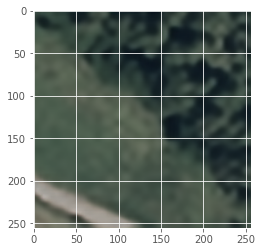

In [22]:
imshow(rgbtensor_to_rgb(pred.detach().cpu())[5])

In [23]:
pred.shape

torch.Size([32, 4, 256, 256])

In [24]:
pred.shape

torch.Size([32, 4, 256, 256])

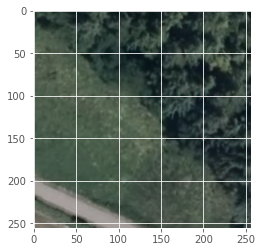

In [25]:
imshow(rgbtensor_to_rgb(img[5:6])[0])

In [26]:
diff = pred.detach().cpu() - img[0][0:1]

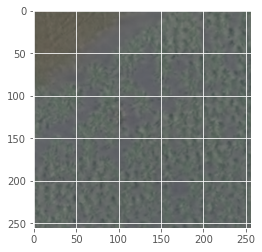

In [27]:
imshow(rgbtensor_to_rgb(diff)[0])

In [98]:
! ls -l

total 691992
-rw-rw-r--   1 werner-ch werner-ch 373564325 Jun  5 23:42 ae.ckpt
-rw-rw-r--   1 werner-ch werner-ch 114349785 Jun  5 23:45 ae_encoder.pth
-rw-rw-r--   1 werner-ch werner-ch 129709156 Jun  5 23:44 ae_full.pth
drwxrwxr-x   2 werner-ch werner-ch      4096 May 19  2021 assets
drwxrwxr-x   2 werner-ch werner-ch      4096 Apr  1 12:50 checkpoints
drwxr-xr-x  11 werner-ch werner-ch      4096 Jun  5 14:58 configs
drwxrwxr-x  18 werner-ch werner-ch      4096 Apr  4 10:22 data
drwxrwxr-x  12 werner-ch werner-ch      4096 Jun  5 14:54 deadtrees
drwxr-xr-x   2 werner-ch werner-ch      4096 Mar 28 22:51 deadtrees.egg-info
drwxrwxr-x   2 werner-ch werner-ch      4096 May 19  2021 docker
-rw-rw-r--   1 werner-ch werner-ch       555 May 19  2021 docker-compose.yml
-rw-rw-r--   1 werner-ch werner-ch     15228 Apr  4 10:22 dvc.lock
-rw-rw-r--   1 werner-ch werner-ch      4049 Mar 29 15:34 dvc.yaml
-rw-rw-r--   1 werner-ch werner-ch      4875 May 17 17:28 eval.py
-rw-r--r--   1 werner-ch we

In [ ]:
import pandas as pd
# Use pandas to align the columns
pd.set_option('display.max_rows', 5000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [17]:
summary(model.to("cuda"), torch.zeros((1, 4, 256, 256)).to("cuda")) 

                                                      Kernel Shape       Output Shape Params   Mult-Adds
Layer                                                                                                   
0_encoder._conv_stem.ZeroPad2d_static_padding                    -   [1, 4, 257, 257]      -           -
1_encoder.BatchNorm2d__bn0                                    [48]  [1, 48, 128, 128]   96.0        48.0
2_encoder.MemoryEfficientSwish__swish                            -  [1, 48, 128, 128]      -           -
3_encoder._blocks.0._depthwise_conv.ZeroPad2d_s...               -  [1, 48, 130, 130]      -           -
4_encoder._blocks.0.BatchNorm2d__bn1                          [48]  [1, 48, 128, 128]   96.0        48.0
...                                                            ...                ...    ...         ...
1697_decoder.blocks.x_0_4.conv2.block.PointWise...  [16, 16, 1, 1]  [1, 16, 256, 256]  272.0  16.777216M
1698_decoder.blocks.x_0_4.conv2.block.BatchNorm...     

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_encoder._conv_stem.ZeroPad2d_static_padding,-,"[1, 4, 257, 257]",NaN,NaN
1_encoder.BatchNorm2d__bn0,[48],"[1, 48, 128, 128]",96.0,4.800000e+01
2_encoder.MemoryEfficientSwish__swish,-,"[1, 48, 128, 128]",NaN,NaN
3_encoder._blocks.0._depthwise_conv.ZeroPad2d_static_padding,-,"[1, 48, 130, 130]",NaN,NaN
4_encoder._blocks.0.BatchNorm2d__bn1,[48],"[1, 48, 128, 128]",96.0,4.800000e+01
5_encoder._blocks.0.MemoryEfficientSwish__swish,-,"[1, 48, 128, 128]",NaN,NaN
6_encoder._blocks.0._se_reduce.Identity_static_padding,-,"[1, 48, 1, 1]",NaN,NaN
7_encoder._blocks.0.MemoryEfficientSwish__swish,-,"[1, 12, 1, 1]",NaN,NaN
8_encoder._blocks.0._se_expand.Identity_static_padding,-,"[1, 12, 1, 1]",NaN,NaN


In [ ]:
Model(**clean_network_conf, classes=n_classes)